# Methods of Estimations

In `Orbit`, we mainly support two methods to estimate model parameters (a.k.a posteriors in Bayesian).

1. Maximum a Posteriori (MAP)
2. Markov Chain Monte Carlo (MCMC)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import orbit
from orbit.utils.dataset import load_iclaims
from orbit.models import ETS
from orbit.diagnostics.plot import plot_predicted_data

In [2]:
print(orbit.__version__)

1.1.1dev


In [3]:
# load data
df = load_iclaims()
test_size = 52
train_df = df[:-test_size]
test_df = df[-test_size:]
response_col = 'claims'
date_col = 'week'

## Maximum a Posteriori (MAP)

To use MAP method, one can simply specify `estimator='stan-map'` when instantiating a model. The advantage of MAP estimation is a faster computational speed. We also provide inference for MAP method, with the caveat that the uncertainty is mainly generated by bootstraping the noise process and as such we may not observe the uncertainty band from seasonality or other components.

In [4]:
%%time
ets = ETS(
    response_col=response_col,
    date_col=date_col,
    estimator='stan-map',
    seasonality=52,
    seed=8888,
)
ets.fit(df=train_df) 
predicted_df = ets.predict(df=test_df)

INFO:orbit:Optimizing(PyStan) with algorithm:LBFGS .


CPU times: user 33.2 ms, sys: 7.52 ms, total: 40.7 ms
Wall time: 274 ms


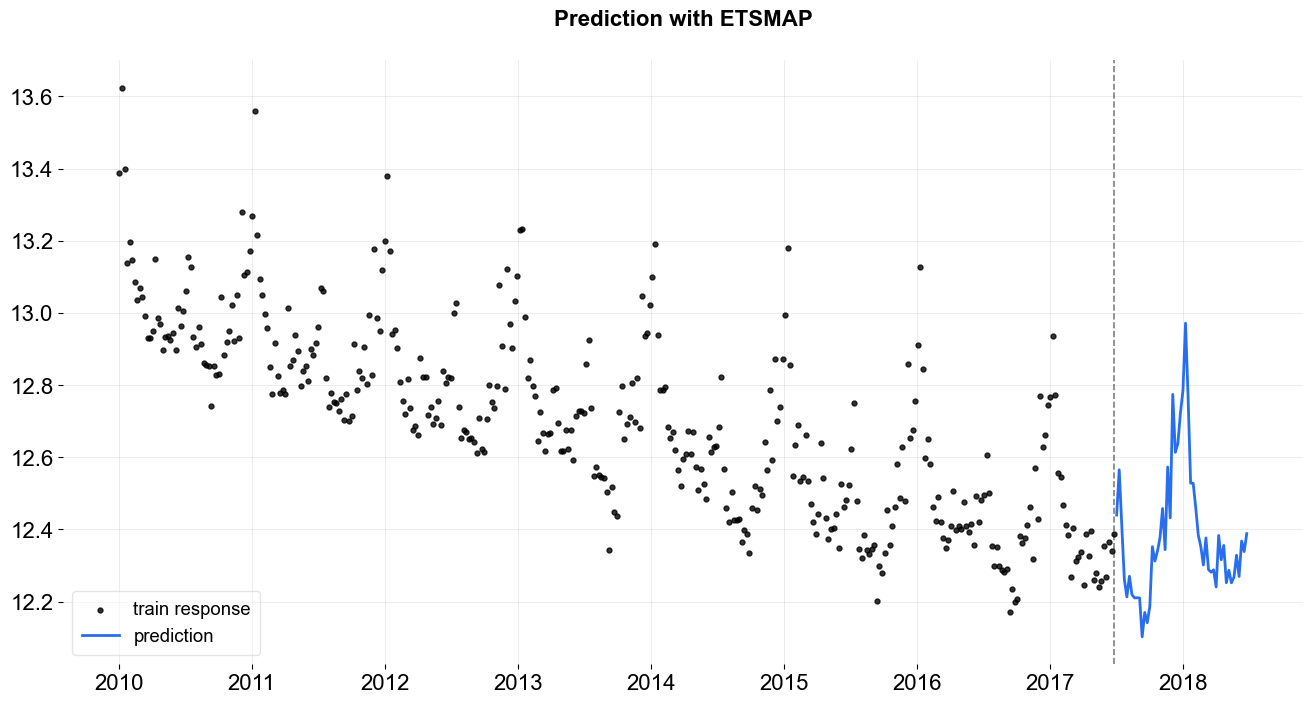

In [5]:
_ = plot_predicted_data(train_df, predicted_df, date_col, response_col, title='Prediction with ETSMAP')

To have the uncertainty from MAP, one can speicify `n_bootstrap_draws` (default to be -1).

INFO:orbit:Optimizing(PyStan) with algorithm:LBFGS .


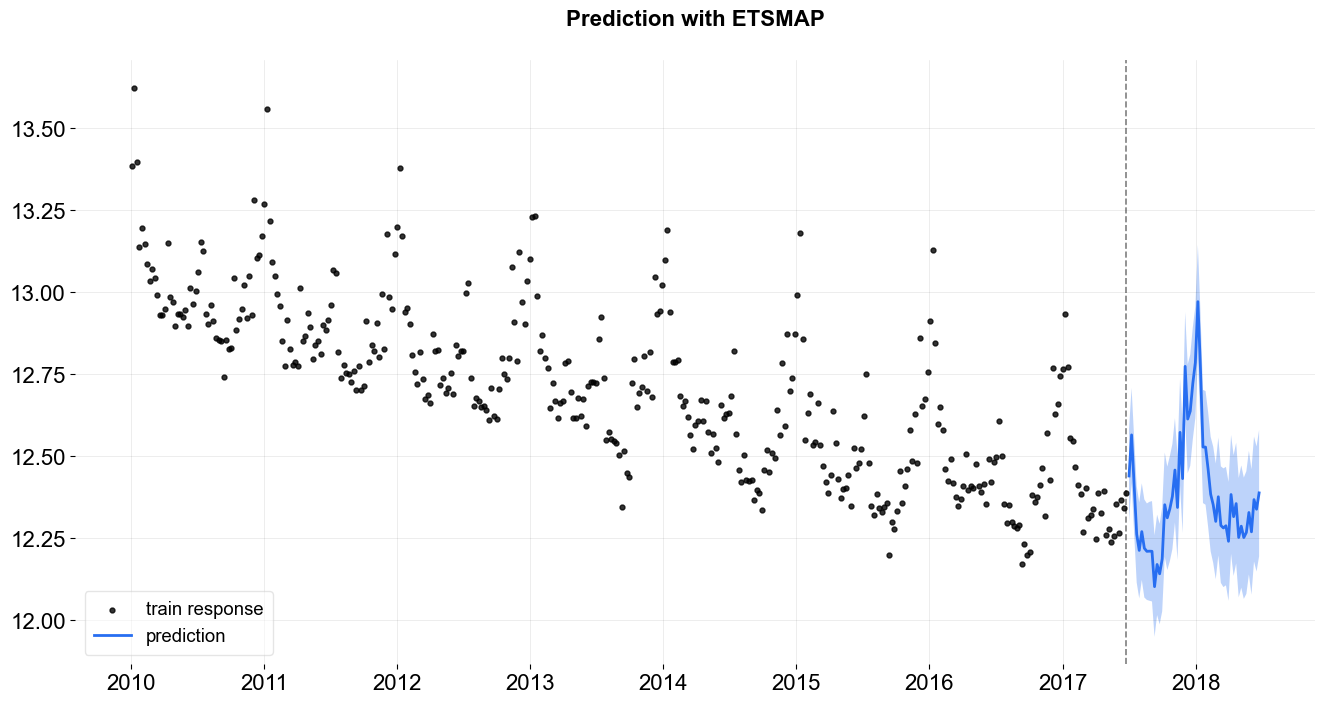

In [6]:
ets = ETS(
    response_col=response_col,
    date_col=date_col,
    estimator='stan-map',
    seasonality=52,
    seed=8888,
    n_bootstrap_draws=1e4
)
ets.fit(df=train_df)
predicted_df = ets.predict(df=test_df)

_ = plot_predicted_data(train_df, predicted_df, date_col, response_col, title='Prediction with ETSMAP')

One can access the posterior estimated by calling the `.get_point_posteriors()`. The outcome from this function is a `dict` of `dict` where the top layer stores the type of point estimate while the second layer stores the parameters labels and values.

In [7]:
ets.get_point_posteriors()['map'].keys()

dict_keys(['l', 'lev_sm', 'obs_sigma', 's', 'sea_sm'])

## MCMC

To use MCMC method, one can specify `estimator='stan-mcmc'` (also the default) when instantiating a model.  Compared to MAP, it usually takes longer time to fit a full Bayesian models where **No-U-Turn Sampler (NUTS)** [(Hoffman and Gelman 2011)](https://arxiv.org/abs/1111.4246) is carried out under the hood. The advantage is that the inference and estimation are usually more robust.

### MCMC - Full

In [8]:
%%time
ets = ETS(
    response_col=response_col,
    date_col=date_col,
    estimator='stan-mcmc',
    seasonality=52,
    seed=8888,
    num_warmup=400,
    num_sample=400,
)
ets.fit(df=train_df)
predicted_df = ets.predict(df=test_df)

INFO:orbit:Sampling(PyStan) with chains:4, cores:8, temperature:1.000, warmups(per chain):100 and samples(per chain):100.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 75.4 ms, sys: 58.3 ms, total: 134 ms
Wall time: 835 ms


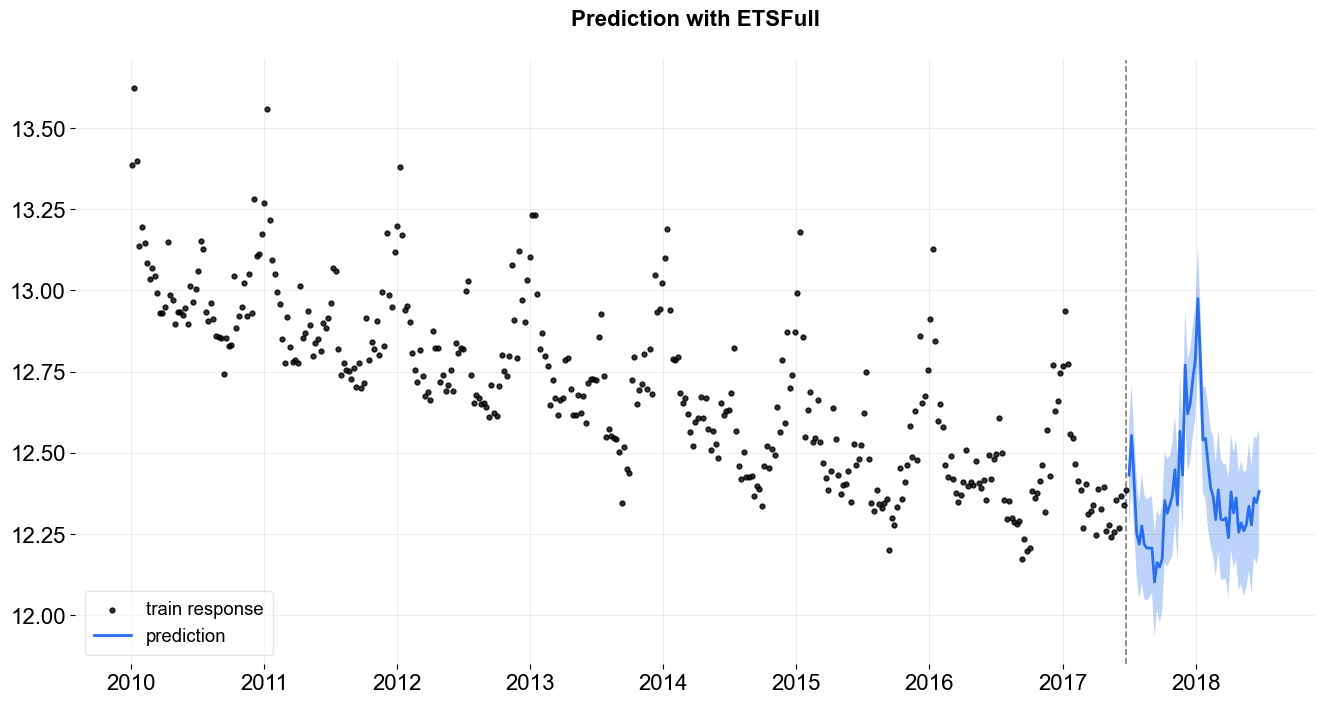

In [9]:
_ = plot_predicted_data(train_df, predicted_df, date_col, response_col, title='Prediction with ETSFull')

Just like the `MAPForecaster`, one can also access the posterior samples by calling the function `.get_posterior_samples()`.

In [10]:
ets.get_posterior_samples().keys()

odict_keys(['l', 'lev_sm', 'obs_sigma', 's', 'sea_sm'])

### MCMC - Point Estimation
One can also have the point estimates via MCMC by specifying `point_method` as `mean` or `median` via `.fit`.
 

Just like the full Bayesian method, it runs through the MCMC algorithm which is **NUTS** by default. The difference from a full model is that it aggregates the posterior samples first based on mean or median then does the prediction once using the aggreated posteriors.

In [11]:
%%time
ets = ETS(
    response_col=response_col,
    date_col=date_col,
    estimator='stan-mcmc',
    seasonality=52,
    seed=8888,
)

CPU times: user 175 µs, sys: 446 µs, total: 621 µs
Wall time: 625 µs


In [12]:
# specify point_method
ets.fit(df=train_df, point_method='mean')
predicted_df = ets.predict(df=test_df)

INFO:orbit:Sampling(PyStan) with chains:4, cores:8, temperature:1.000, warmups(per chain):225 and samples(per chain):25.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


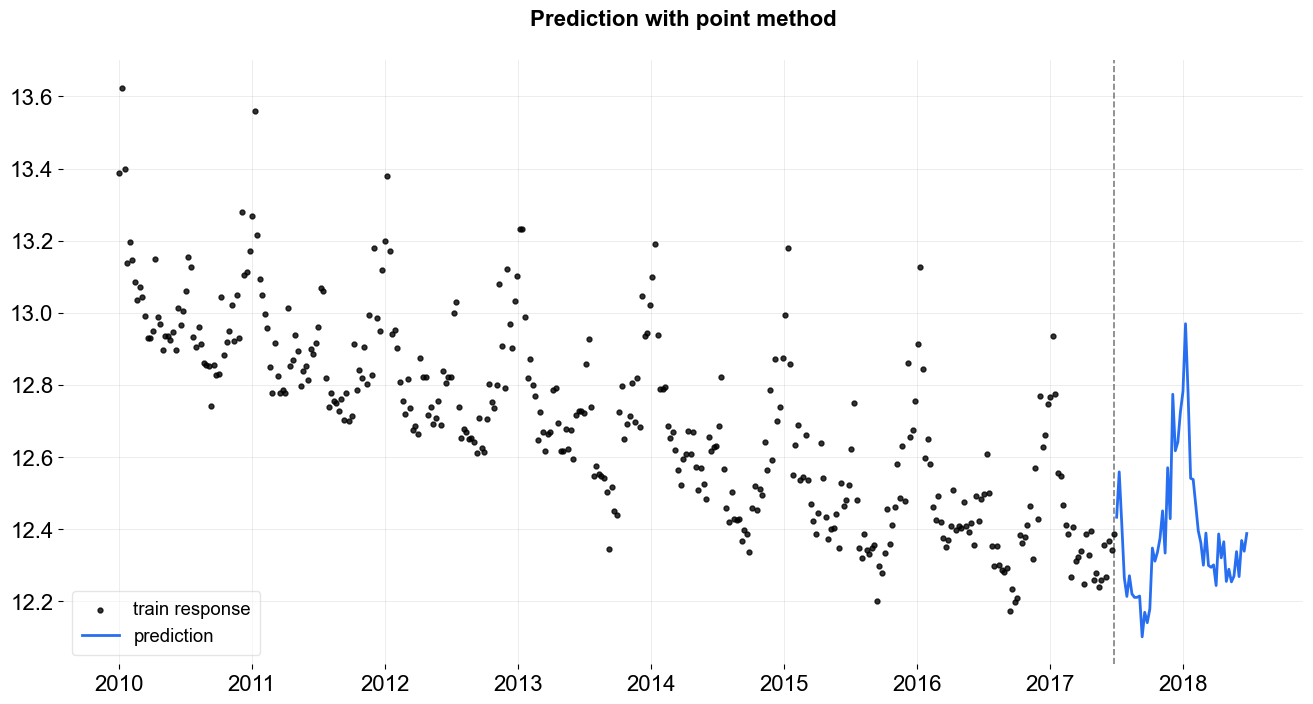

In [13]:
_ = plot_predicted_data(train_df, predicted_df, date_col, response_col, 
                        title='Prediction with point method')

Similarly, one can also specify `n_bootstrap_draws` to have the uncertainty for the point estimates.

INFO:orbit:Sampling(PyStan) with chains:4, cores:8, temperature:1.000, warmups(per chain):225 and samples(per chain):25.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


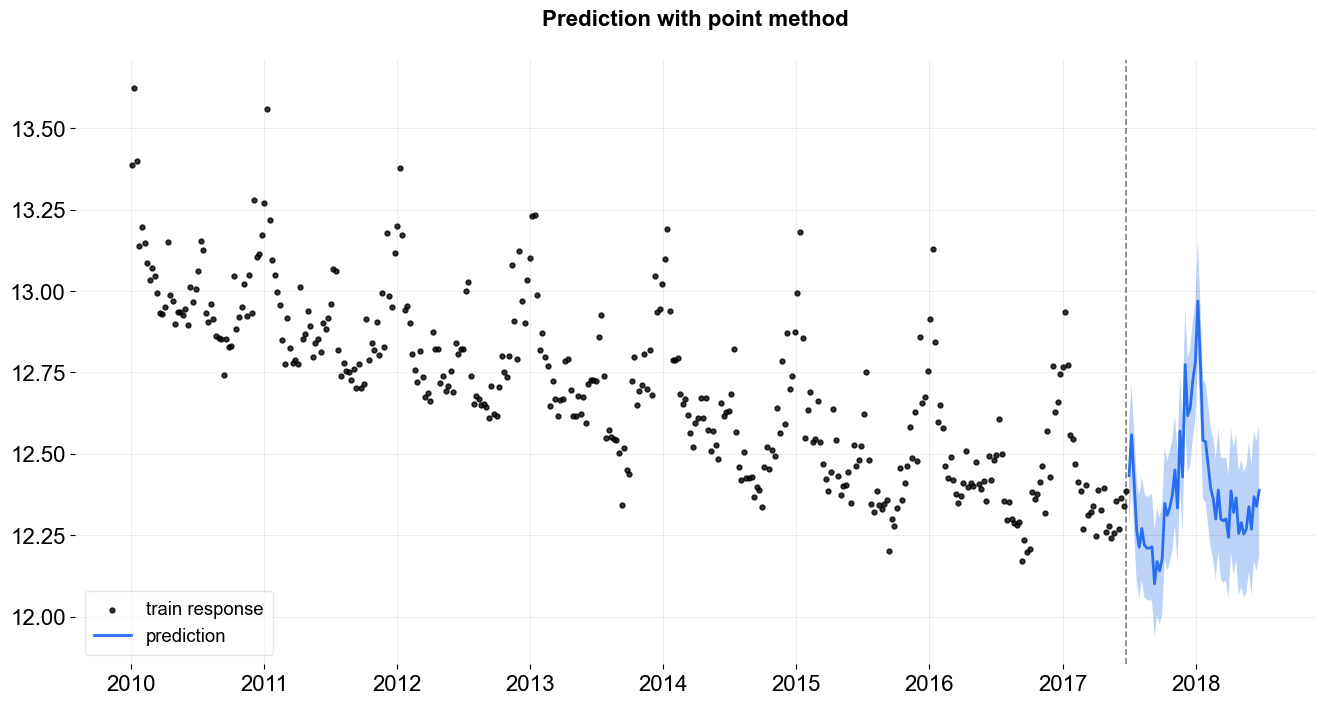

CPU times: user 1.07 s, sys: 238 ms, total: 1.31 s
Wall time: 1.57 s


In [14]:
%%time
ets = ETS(
    response_col=response_col,
    date_col=date_col,
    estimator='stan-mcmc',
    seasonality=52,
    seed=8888,
    n_bootstrap_draws=1e4,
)
# specify point_method
ets.fit(df=train_df, point_method='mean')
predicted_df = ets.predict(df=test_df)

_ = plot_predicted_data(train_df, predicted_df, date_col, response_col, 
                        title='Prediction with point method')

One can always access the the point estimated posteriors by `.get_point_posteriors()` (including the cases fitting the parameters through MCMC).

In [15]:
ets.get_point_posteriors()['mean'].keys()

dict_keys(['l', 'lev_sm', 'obs_sigma', 's', 'sea_sm'])

In [16]:
ets.get_point_posteriors()['median'].keys()

dict_keys(['l', 'lev_sm', 'obs_sigma', 's', 'sea_sm'])